# DATA 607 Final Project
# Analysis of Railroad Accidents in the United States
Team Members:
*   ​Gregory Mathurin
*   ​Soyebal Saad Adnan
*   Ray Al-Saidi



---







**Introduction**

This report delves into the realm of transportation safety, with an emphasis on analyzing railroad accidents across the United States. The core aim is to dissect the patterns and fundamental causes that underpin these accidents, offering a detailed examination of the various factors involved. Through a careful analysis of diverse variables associated with railroad incidents, this study strives to unveil prevailing trends, pinpoint causal elements, and highlight areas ripe for safety enhancements. The implications of this research are significant, poised to bolster railroad safety measures, guide policy-making, and ultimately diminish the frequency and gravity of such accidents. The scope of this investigation covers all documented railroad accidents within the specified period, scrutinizing key aspects such as the timing, locations, environmental settings, characteristics of the trains involved, and the consequent outcomes, including damages, injuries, costs, and fatalities.



**The importance of railroads and the Freight Rail Network in the United Stated**

•	provides more than 167,000 jobs

•	$80-billion freight rail industry

•	52 percent of rail freight car loads consist of bulk commodities such as agriculture and energy products, automobiles and components

As we try to understand the impact of railroad accidents, we thought it would be prudent to focus on the frequency of these events through a time series analysis, measure the financial impact through regression analysis of the total damage cost and lastly categorize the different accident types which occur to potential highlight the ones that more common and potentially more threatening.

**Dataset**

This report leverages a dataset obtained from Form 6180.54 accident reports, an extensive repository of data on railroad accidents mandated by the relevant transportation authority. Initiated on April 4, 2023, and most recently updated on March 25, 2024, this dataset includes roughly 219,000 entries and 161 columns, encapsulating a wide array of variables associated with railroad accidents. These variables detail numerous aspects such as the date and location of the accident, environmental conditions, train characteristics, and the impacts in terms of damages and casualties. Each entry in the dataset represents a unique incident, offering detailed insights into the particular conditions and outcomes of each accident.

The dataset is accessible under a public domain license, available at http://www.usa.gov/publicdomain/label/1.0/, which permits its use in research and analysis without necessitating explicit permission.

**Objectives**

* Develop a predictive model using K-Nearest Neighbors (KNN) and Support Vector
Machine (SVM) algorithms to accurately classify the types of accidents based on the provided dataset, enhancing the understanding and categorization of accident occurrences.

* Implement and compare various regression techniques, including Kernel Regression, Principal Component Analysis (PCA) Regression, and Lasso/Ridge Regression, to predict the total damage cost associated with each accident, aiming to provide a quantitative assessment of financial impacts.

* Conduct a time series analysis focusing on the accident types within the three states recording the highest number of accidents, aiming to identify trends, patterns, and potential seasonal or temporal factors influencing accident rates in these regions.

**Imported Libraries**

In [ ]:
## libraries imported
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer, PowerTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore




**Initial Data Cleaning**

The code reads the file directly from the source and loads it into a dataframe named df_project. It also removes any leading whitespace from all the cells.



In [ ]:
#URL: https://catalog.data.gov/dataset/rail-equipment-accident-incident-data

# Read the CSV with dtype specified if you know the types; otherwise, read a small sample to inspect types
#df_project = pd.read_csv("Rail_Equipment_Accident_Incident_Data__Form_54_.csv", skipinitialspace=True)


df_project = pd.read_csv('https://data.transportation.gov/api/views/85tf-25kj/rows.csv?accessType=DOWNLOAD',skipinitialspace=True)


# Assuming you want to strip whitespace from string columns
for col in df_project.columns:
    if df_project[col].dtype == 'object':
        df_project[col] = df_project[col].str.strip()

# Check the DataFrame's information again


C:\Users\rayal\AppData\Local\Temp\ipykernel_9388\797150502.py:7: DtypeWarning: Columns (27,43,46,47,48,50,59,61,62,63,64,65,66,67,68,69,71,130,131,136,160) have mixed types. Specify dtype option on import or set low_memory=False.
  df_project = pd.read_csv('https://data.transportation.gov/api/views/85tf-25kj/rows.csv?accessType=DOWNLOAD',skipinitialspace=True)


If we drop all rows with missing values, we end up with no data at all. Therefore, we eliminated any columns that had more than 15% missing values.

In [ ]:

# Create a list to hold columns to drop
columns_to_drop = []

# Calculate the threshold for dropping columns
threshold = len(df_project) *0.15

# Identify columns that meet the criteria for dropping
for col in df_project.columns:
    if df_project[col].isnull().sum() > threshold:
        columns_to_drop.append(col)

# Drop the identified columns
df_project.drop(columns=columns_to_drop, axis=1, inplace=True)

# Print the DataFrame info
df_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219203 entries, 0 to 219202
Columns: 104 entries, Reporting Railroad Code to Maintenance Railroad Holding Company
dtypes: float64(10), int64(49), object(45)
memory usage: 173.9+ MB


Lets check if any of the columns are in fact binary in nature

In [ ]:
def print_binary_columns(df):
    # Initialize an empty list to hold the names of binary columns
    binary_columns = []

    for col in df.columns:
        # Drop null values and then count unique values in the column
        unique_non_null = df[col].dropna().unique()

        # Check if the number of unique non-null values is exactly 2
        if len(unique_non_null) == 2:
            binary_columns.append(col)

    # Print the names of binary columns
    if binary_columns:
        print("Binary columns:")
        for col in binary_columns:
            print(col)
    else:
        print("No binary columns found.")

# Test the function with your DataFrame
# Replace 'your_dataframe' with your actual DataFrame variable


print_binary_columns(df_project)

Binary columns:
Passengers Transported


Lets change this column 'Passengers Transported' to categorical type

In [ ]:
df_project['Passengers Transported'] = df_project['Passengers Transported'].astype('category')

We also need to change the date to proper data type

In [ ]:
df_project['Date'] = pd.to_datetime(df_project['Date'], format='%d-%m-%Y', errors='coerce')

**OBJECTIVE 1: Accident Type Classification**

My target variable for the classification is accident type. I will drop the nan values for the column Accident Type, and the Other (describe in narrative) since there is another Other classification

In [ ]:
df_objective_1=df_project
df_objective_1['Accident Type'].unique()

array(['Derailment', 'Rear end collision', 'Other impacts',
       'Other (describe in narrative)', 'Side collision',
       'Raking collision', 'Fire/violent rupture', 'Head on collision',
       'Hwy-rail crossing', 'Obstruction', 'Broken train collision',
       'Explosion-detonation', 'RR grade crossing', nan], dtype=object)

In [ ]:
df_objective_1 = df_objective_1[(df_objective_1['Accident Type'] != 'Other (describe in narrative)') & (df_objective_1['Accident Type'].notna())]
df_objective_1['Accident Type'].unique()


array(['Derailment', 'Rear end collision', 'Other impacts',
       'Side collision', 'Raking collision', 'Fire/violent rupture',
       'Head on collision', 'Hwy-rail crossing', 'Obstruction',
       'Broken train collision', 'Explosion-detonation',
       'RR grade crossing'], dtype=object)

In [ ]:
df_objective_1['Accident Type'].isnull().sum()

0

In [ ]:
df_objective_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214631 entries, 0 to 219202
Columns: 104 entries, Reporting Railroad Code to Maintenance Railroad Holding Company
dtypes: category(1), float64(10), int64(49), object(44)
memory usage: 170.5+ MB


In [ ]:
columns_to_drop = [
    'Accident Year',              ## Same information in the Date column
    'Accident Month',             ## Same information in the Date column
    'Maintenance Accident Year',    ## Same information in the Date column
    'Maintenance Accident Month',   ## Same information in the Date column
    'Day',                           ## Same information in the Date column
    'Year',                           ## Same information in the Date column
    'Equipment Damage Cost',        ## Similar Information is in the total damage cost
    'Track Damage Cost',            ## Similar Information is in the total damage cost
    'PDF Link',                   # PDF link for accident report (useless for classification)
    'Visibility Code',                 # Same information is in the visibility code column
    'Division',              # Same information is in the Division column
    'Accident Number',            # Generic primary key column that is useless for classification
    'Narrative',                 # Blob of text that is useless for classification
    'Primary Accident Cause',     # Blob of text that is useless for classification
    'Accident Cause',             # text explanation of the cause of accident
    'Accident Type Code',         # (similar to our target variable)
    'State Abbreviation',        # same information in the state Name
    'Incident Key',              # Accident tracking serial code, useless for our needs.
    'Report Key',                  # Accident tracking serial code, useless for our needs.
    'Maintenance Accident Number', # tracking serial number - useless
    'Accident Cause Code',            # same information as primary accident cause code.
    'County Code',                   # same information is in the County name
    'State Code',
    'Maintenance Railroad Code',          ## these 5 have the same information,
    'Reporting Parent Railroad Code',
    'Maintenance Parent Railroad Code',
    'Maintenance Railroad Name',
    'Reporting Railroad Holding Company',



    #### Additional columns that aren't needed for objective 1
    'Time',
    'Class Code',
    'Joint Track Type',                  # similar information in the class code column
    'Reporting Railroad Class',         # similar information in the class code column
    'Maintenance Railroad Class',       # similar information in the class code column
    'Reporting Railroad Class',          # similar information in the class code column
    'Weather Condition Code',                   # same data in weather condition code
    'Maintenance Railroad Holding Company', # same info as Reporting Railroad Name
    'Maintenance Parent Railroad Name',    # same info as Reporting Railroad Name
    'Reporting Parent Railroad Name',     # same info as Reporting Railroad Name
    'Reporting Railroad SMT Grouping'    # same info as Maintenance Railroad SMT Grouping




]

df_objective_1 = df_objective_1.drop([col for col in columns_to_drop if col in df_objective_1.columns], axis=1)



This will be used later to do KNN/Scaling then compare the accuracy to the imputed dataframe

In [ ]:

df_objective_1_rmnan=df_objective_1.dropna()
df_objective_1_rmnan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126407 entries, 5 to 219202
Data columns (total 67 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   Reporting Railroad Code                126407 non-null  object  
 1   Reporting Railroad Name                126407 non-null  object  
 2   Date                                   126407 non-null  object  
 3   Accident Type                          126407 non-null  object  
 4   Hazmat Cars                            126407 non-null  int64   
 5   Hazmat Cars Damaged                    126407 non-null  int64   
 6   Hazmat Released Cars                   126407 non-null  int64   
 7   Persons Evacuated                      126407 non-null  int64   
 8   Station                                126407 non-null  object  
 9   Milepost                               126407 non-null  object  
 10  State Name                             126407 non

In [ ]:
df_objective_1_rmnan.isnull().sum()

Reporting Railroad Code              0
Reporting Railroad Name              0
Date                                 0
Accident Type                        0
Hazmat Cars                          0
                                    ..
Total Killed Form 54                 0
Total Injured Form 54                0
Class                                0
Joint CD                             0
Maintenance Railroad SMT Grouping    0
Length: 67, dtype: int64

Splitting the data with missing values

In [ ]:
y_1 = df_objective_1['Accident Type']
X_1 = df_objective_1.drop(['Accident Type'], axis=1)          
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

Splitting the data with no missing values

In [ ]:
y_1_rmnan = df_objective_1_rmnan['Accident Type']
X_1_rmnan = df_objective_1_rmnan.drop(['Accident Type'], axis=1)          
X_train_1_rmnan, X_test_1_rmnan, y_train_1_rmnan, y_test_1_rmnan = train_test_split(X_1_rmnan, y_1_rmnan, test_size=0.2, random_state=42)

Now I will split the columns to numerical and categorical columns to impute ane encode data. The function below takes a dataframe, extracts the numerical columns, then print the variance and other different stats for each column

In [ ]:
def print_numeric_features_stats(df):
    """
    Print the range and variance for each numeric feature in the DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    # Select numeric features from the DataFrame
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

    # Iterate over each numeric feature to calculate and print its range and variance
    for feature in numeric_features:
        # Calculate the range (max - min) of the feature
        feature_range = df[feature].max() - df[feature].min()

        # Calculate the variance of the feature
        feature_variance = df[feature].var()

        # Print the feature name, its range, and its variance
        print(f"Feature: {feature}, Range: {feature_range}, Variance: {feature_variance}")

print_numeric_features_stats(X_train_1)
print_numeric_features_stats(X_test_1)


Feature: Hazmat Cars, Range: 182, Variance: 39.06654259602255
Feature: Hazmat Cars Damaged, Range: 98, Variance: 1.0724244988575897
Feature: Hazmat Released Cars, Range: 32, Variance: 0.080129516692757
Feature: Persons Evacuated, Range: 50000, Variance: 25506.985066555208
Feature: District, Range: 7, Variance: 3.764064913006774
Feature: Temperature, Range: 922, Variance: 530.9368395936912
Feature: Train Speed, Range: 135.0, Variance: 216.72255150815306
Feature: Maximum Speed, Range: 135, Variance: 235.18734743316335
Feature: Gross Tonnage, Range: 97000, Variance: 18987845.363512594
Feature: First Car Position, Range: 902.0, Variance: 804.5342623894201
Feature: Head End Locomotives, Range: 29, Variance: 2.3811421067928453
Feature: Mid Train Manual Locomotives, Range: 9, Variance: 0.04717104156486085
Feature: Mid Train Remote Locomotives, Range: 9, Variance: 0.047617731882471585
Feature: Rear End Manual Locomotives, Range: 9, Variance: 0.1016079095384919
Feature: Rear End Remote Locomoti

This code is designed to encode categorical features using a label encoder. A one-hot encoder is not suitable in this scenario due to the large number of categorical variables and rows, as its use led to the program crashing. Therefore, we chose to use the label encoder instead.








In [ ]:

def encode_categorical(dataframe):
    """
    Encodes categorical variables in the dataframe using Label Encoding, while leaving null or NaN values intact.

    Parameters:
    dataframe (pd.DataFrame): The dataframe to encode.

    Returns:
    encoded_df (pd.DataFrame): The dataframe with categorical variables encoded.
    encoding_info (dict): A dictionary containing the LabelEncoders for each categorical column.
    """
    # Ensure the dataframe's categorical columns are properly identified
    categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns

    # If no categorical columns are found, return a message
    if not categorical_cols.size > 0:
        print("No categorical columns found to encode.")
        return dataframe, {}

    numerical_df = dataframe.select_dtypes(exclude=['object', 'category'])
    encoded_df = numerical_df.copy()
    encoding_info = {}

    for col in categorical_cols:
        encoder = LabelEncoder()
        # Select non-null data for fitting the encoder
        valid_data = dataframe[col][dataframe[col].notnull()]
        if valid_data.empty:
            continue  # Skip encoding if the column has only null values
        encoder.fit(valid_data)
        # Initialize encoded column with NaNs and replace non-null entries with encoded values
        encoded_series = pd.Series(index=dataframe.index, dtype='float64')
        encoded_series[valid_data.index] = encoder.transform(valid_data)
        encoded_df[col] = encoded_series
        encoding_info[col] = encoder

    return encoded_df, encoding_info

def apply_encoding(dataframe, encoding_info):
    numerical_df = dataframe.select_dtypes(exclude=['object', 'category'])
    encoded_df = numerical_df.copy()

    for col, encoder in encoding_info.items():
        if col in dataframe:
            # Initialize the column with NaN
            encoded_df[col] = np.nan
            non_null_index = dataframe[col].notnull()
            # Only apply encoding to non-null values
            if non_null_index.any():
                encoded_df.loc[non_null_index, col] = encoder.transform(dataframe.loc[non_null_index, col])
        else:
            encoded_df[col] = np.nan

    return encoded_df

In [ ]:

X_train_1_encoded, X_train_1_encoding = encode_categorical(X_train_1)
X_test_1_encoded, X_test_1_encoding = encode_categorical(X_test_1)


Now lets encode the target variable

In [ ]:
encoder = LabelEncoder()

# Fit the encoder on the training data and transform it
y_train_1_encoded = encoder.fit_transform(y_train_1)

# Transform the testing data using the same encoder
y_test_1_encoded = encoder.transform(y_test_1)

## for the non-imputed data



In [ ]:
## for the non-imputed data
X_train_1_rmnan_encoded, X_train_1_rmnan_encoding = encode_categorical(X_train_1_rmnan)
X_test_1_rmnan_encoded, X_test_1_rmnan_encoding = encode_categorical(X_test_1_rmnan)

encoder_rmnon = LabelEncoder()

# Fit the encoder on the training data and transform it
y_train_1_encoded_rmnon = encoder_rmnon.fit_transform(y_train_1_rmnan)

# Transform the testing data using the same encoder
y_test_1_encoded_rmnon = encoder_rmnon.transform(y_test_1_rmnan)

Each set will be scaled then imputed with fitting the test data

In [ ]:

# Identify all numerical columns (excluding the target variable, if it's in the same DataFrame)
print("Identifying all numerical columns...")
numerical_cols = X_train_1_encoded.select_dtypes(include=[np.number]).columns

# Initialize the scaler and imputer
print("Initializing the scaler and imputer...")
scaler = StandardScaler()
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

# Scaling the numerical columns for the train set
print("Scaling the numerical columns for the train set...")
X_train_1_encoded_scaled = scaler.fit_transform(X_train_1_encoded[numerical_cols].astype(np.float64))
X_train_1_encoded_scaled_df = pd.DataFrame(X_train_1_encoded_scaled, columns=numerical_cols, index=X_train_1_encoded.index)

# Apply the same scaling to the test set
print("Scaling the numerical columns for the test set...")
X_test_1_encoded_scaled = scaler.transform(X_test_1_encoded[numerical_cols].astype(np.float64))
X_test_1_encoded_scaled_df = pd.DataFrame(X_test_1_encoded_scaled, columns=numerical_cols, index=X_test_1_encoded.index)

# Imputing the missing values in the scaled train set using Iterative Imputer
print("Imputing the missing values in the scaled train set using Iterative Imputer...")
X_train_1_encoded_imputed_scaled = iterative_imputer.fit_transform(X_train_1_encoded_scaled_df)
X_train_1_encoded_imputed_scaled_df = pd.DataFrame(X_train_1_encoded_imputed_scaled, columns=numerical_cols, index=X_train_1_encoded.index)

# Apply the same imputation to the test set (without fitting)
print("Imputing the missing values in the scaled test set using the trained Iterative Imputer...")
X_test_1_encoded_imputed_scaled = iterative_imputer.transform(X_test_1_encoded_scaled_df)
X_test_1_encoded_imputed_scaled_df = pd.DataFrame(X_test_1_encoded_imputed_scaled, columns=numerical_cols, index=X_test_1_encoded.index)

# Combine the imputed and scaled features with the target variable for both train and test sets
train_df_imputed = pd.concat([X_train_1_encoded_imputed_scaled_df, y_train], axis=1)
test_df_imputed = pd.concat([X_test_1_encoded_imputed_scaled_df, y_test], axis=1)

print("Data processing completed.")


Identifying all numerical columns...
Initializing the scaler and imputer...
Scaling the numerical columns for the train set...
Scaling the numerical columns for the test set...
Imputing the missing values in the scaled train set using Iterative Imputer...
Imputing the missing values in the scaled test set using the trained Iterative Imputer...
Data processing completed.


**KNN Classification**

Now we can try KNN classification, we wil find the best k using cross validation

In [ ]:

# Ensure X_train and X_test refer to the imputed and scaled data
X_train = X_train_1_encoded_imputed_scaled_df
X_test = X_test_1_encoded_imputed_scaled_df
y_train = y_train_1_encoded
y_test= y_test_1_encoded
# Finding the best k using cross-validation
print("Finding the best k value...")
k_range = range(1, 31)  # Adjust the range based on your dataset and requirements
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')  # Using accuracy as the metric
    k_scores.append(scores.mean())

# Best k value
best_k = k_range[np.argmax(k_scores)]
print(f"Best k: {best_k}")

# Train the KNN model with the best k value
print("Training the KNN model with the best k value...")
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Evaluate the model on the testing set
print("Evaluating the model on the testing set...")
accuracy = knn_best.score(X_test, y_test)
print(f"Test set accuracy: {accuracy}")

Finding the best k value...
Best k: 19
Training the KNN model with the best k value...
Evaluating the model on the testing set...
Test set accuracy: 0.7251613203811121


In the process of optimizing a K-Nearest Neighbors (KNN) model, determining the best number of neighbors (k) is crucial for accuracy. After analyzing the imputed data, the best k value was identified as 19. Following this selection, the model was trained using these 19 neighbors. Upon evaluation on the testing set, the model achieved a test set accuracy of approximately 72.52%. This result underscores the importance of choosing an appropriate k value in the effectiveness of the KNN model for making accurate predictions.

Attempting KNN with non imputed dataframe, this code include scaling as well


In [ ]:
X_train_nan= X_train_1_rmnan_encoded
X_test_nan = X_test_1_rmnan_encoded
y_train_nan = y_train_1_encoded_rmnon
y_test_nan= y_test_1_encoded_rmnon

# Fit the encoder on the training data and transform it
y_train_1_encoded_rmnon = encoder_rmnon.fit_transform(y_train_1_rmnan)

# Transform the testing data using the same encoder
y_test_1_encoded_rmnon = encoder_rmnon.transform(y_test_1_rmnan)

# Combine the training and test feature sets for encoding
X_combined = pd.concat([X_train_nan, X_test_nan], axis=0)

# Encoding categorical features
for col in X_combined.columns:
    if X_combined[col].dtype == 'object':
        encoder = LabelEncoder()
        X_combined[col] = encoder.fit_transform(X_combined[col])

# Splitting the combined data back into training and test sets
X_train_nan = X_combined.iloc[:X_train_nan.shape[0], :]
X_test_nan = X_combined.iloc[X_train_nan.shape[0]:, :]

# Resetting the index to avoid potential issues later on
X_train_nan.reset_index(drop=True, inplace=True)
X_test_nan.reset_index(drop=True, inplace=True)

# Initialize scalers and KNN classifier within pipelines
pipeline_standard = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pipeline_quantile = Pipeline([('scaler', QuantileTransformer(output_distribution='normal')), ('knn', KNeighborsClassifier())])

# Function to find the best k and evaluate the model
def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    k_range = range(1, 31)
    k_scores = []

    for k in k_range:
        pipeline.set_params(knn__n_neighbors=k)
        scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())

    best_k = k_range[np.argmax(k_scores)]
    print(f"Best k: {best_k}")

    # Training the model with the best k
    pipeline.set_params(knn__n_neighbors=best_k)
    pipeline.fit(X_train, y_train)

    # Evaluating the model on the test set
    accuracy = pipeline.score(X_test, y_test)
    print(f"Test set accuracy: {accuracy}")

# Evaluate the model using standard scaling
print("Evaluating model with Standard Scaling...")
evaluate_model(pipeline_standard, X_train_nan, y_train_nan, X_test_nan, y_test_nan)

# Evaluate the model using quantile scaling
print("\nEvaluating model with Quantile Scaling...")
evaluate_model(pipeline_quantile, X_train_nan, y_train_nan, X_test_nan, y_test_nan)




Evaluating model with Standard Scaling...


Best k: 20
Test set accuracy: 0.7310734910212799

Evaluating model with Quantile Scaling...
Best k: 27
Test set accuracy: 0.7784985365081877


In the evaluation of the model with different scaling methods using the non-imputed data, two approaches were notably compared: Standard Scaling and Quantile Scaling. When the model was evaluated using Standard Scaling, the optimal number of neighbors (k) was determined to be 20, resulting in a test set accuracy of approximately 73.11%. However, a different approach using Quantile Scaling demonstrated a more effective performance, where the best k value was found to be 27, achieving a higher test set accuracy of approximately 77.85%. This indicates that Quantile Scaling may be more suitable for handling this specific dataset, as it led to better predictive accuracy.

Comparing the performance of the K-Nearest Neighbors (KNN) model on two different datasets—imputed and non-imputed—reveals insightful differences in predictive accuracy. For the imputed dataset, where missing values were addressed, the optimal number of neighbors was found to be 19, yielding a test set accuracy of about 72.52%. Conversely, when evaluating the model with non-imputed data using Standard Scaling, the best k increased slightly to 20, but this adjustment led to a marginally higher test set accuracy of approximately 73.11%.

The difference in accuracy, although small, suggests that handling missing values (data imputation) slightly reduces the model's effectiveness compared to using a dataset without imputation but with standard scaling applied. This could indicate that the non-imputed data, possibly being more representative of the real-world scenario despite potential data issues, may be yielding a slightly more robust model. Thus, in this context, the model trained on the non-imputed dataset with Standard Scaling performed better, making it the preferable choice for achieving higher accuracy in predictions.

**Random Forest**

Lets try using random forest classification to see if we get a better result

In [ ]:

X_train_rf= X_train_1_rmnan_encoded
X_test_rf = X_test_1_rmnan_encoded
y_train_rf = y_train_1_encoded_rmnon
y_test_rf= y_test_1_encoded_rmnon

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)  # You can adjust the parameters as needed

# Evaluate the model using cross-validation
print("Evaluating Random Forest model using cross-validation...")
cv_scores = cross_val_score(rf, X_train_rf, y_train_rf, cv=10, scoring='accuracy')  # Using 10-fold cross-validation

# Report the cross-validation accuracy
print(f"CV Accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

# Train the Random Forest model on the full training set
print("Training the Random Forest model on the full training set...")
rf.fit(X_train_rf, y_train_rf)

# Evaluate the model on the testing set
print("Evaluating the model on the testing set...")
accuracy = rf.score(X_test_rf, y_test_rf)
print(f"Test set accuracy: {accuracy}")


Evaluating Random Forest model using cross-validation...


CV Accuracy: 0.8436490080993007 ± 0.0024754197753303025
Training the Random Forest model on the full training set...
Evaluating the model on the testing set...
Test set accuracy: 0.7953089154339056


The evaluation of the Random Forest model shows a disparity between cross-validation and testing accuracies. In cross-validation, the model achieved a robust accuracy of about 84.36% with a very narrow confidence interval (±0.25%), indicating consistent performance across different subsets of the data. However, when tested on a separate testing set after training on the full dataset, the accuracy dropped to approximately 79.53%.

This reduction could be due to potential overfitting, where the model is too tailored to the training data, or differences in data distribution between the training and testing sets. It suggests the model may not generalize as well when exposed to new data. Hence, we will attempt using AdaBoost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


X_train_ad= X_train_1_rmnan_encoded
X_test_ad = X_test_1_rmnan_encoded
y_train_ad = y_train_1_encoded_rmnon
y_test_ad= y_test_1_encoded_rmnon

# Initialize AdaBoost
ada = AdaBoostClassifier(random_state=42)  # You can adjust the parameters as needed

# Evaluate AdaBoost using cross-validation
print("Evaluating AdaBoost model using cross-validation...")
cv_scores = cross_val_score(ada, X_train_ad, y_train_ad, cv=10, scoring='accuracy')

# Report the cross-validation accuracy
print(f"CV Accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

# Train AdaBoost on the full training set
print("Training the AdaBoost model on the full training set...")
ada.fit(X_train_ad, y_train_ad)

# Evaluate the model on the testing set
print("Evaluating the AdaBoost model on the testing set...")
accuracy = ada.score(X_test_ad, y_test_ad)
print(f"Test set accuracy: {accuracy}")


Evaluating AdaBoost model using cross-validation...


C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent th

CV Accuracy: 0.7230555189178736 ± 0.05474650478285443
Training the AdaBoost model on the full training set...


C:\Users\rayal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Evaluating the AdaBoost model on the testing set...
Test set accuracy: 0.6940906573847005



The AdaBoost model evaluated shows a cross-validation (CV) accuracy of approximately 72.31% with a standard deviation of 5.47%, indicating a reasonable predictive ability, though with some variation in performance across different subsets of the data. When the model is applied to the testing set after training on the full dataset, the accuracy decreases to about 69.41%. This drop suggests that the model may be experiencing overfitting, as it performs better on the training data than on new, unseen data. The lower performance on the test set highlights the need for potential adjustments in the model's complexity or the training approach to improve its generalization capabilities.



**Neural Networks**

Finally, we will use neural networks to classify accident types using imputed and non-imputed dataframes

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Predefined data sets
X_train_ad = X_train_1_rmnan_encoded
X_test_ad = X_test_1_rmnan_encoded
y_train_ad = y_train_1_encoded_rmnon
y_test_ad = y_test_1_encoded_rmnon

# Check if y_train_ad needs to be one-hot encoded
if len(y_train_ad.shape) == 1:
    y_train_ad = to_categorical(y_train_ad)
    y_test_ad = to_categorical(y_test_ad)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ad)
X_test_scaled = scaler.transform(X_test_ad)

# Define the model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Correct input layer usage
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train_ad.shape[1], activation='softmax')  # Ensures the output layer matches the number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_ad, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_ad)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7432 - loss: 0.8521 - val_accuracy: 0.7947 - val_loss: 0.6355
Epoch 2/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8003 - loss: 0.6166 - val_accuracy: 0.8068 - val_loss: 0.5982
Epoch 3/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8105 - loss: 0.5735 - val_accuracy: 0.8090 - val_loss: 0.5888
Epoch 4/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8183 - loss: 0.5531 - val_accuracy: 0.8143 - val_loss: 0.5667
Epoch 5/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8240 - loss: 0.5284 - val_accuracy: 0.8148 - val_loss: 0.5691
Epoch 6/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8258 - loss: 0.5233 - val_accuracy: 0.8191 - val_loss: 0.5675
Epoch 7/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8306 - loss: 0.5080 - val_accuracy: 0.8204 - val_loss: 0.5598
Epoch 8/50
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8322 - loss: 0.4991 - 

Using the non-imputed, the model displayed a progressive improvement in accuracy and a corresponding decrease in loss, as demonstrated by its training and validation metrics. Initially, the model started with a training accuracy of 74.32% and a validation accuracy of 79.47%, which indicates that it was performing better on the validation set than on the training set initially, possibly suggesting some underfitting.

As training progressed, both the training and validation accuracies improved, with training accuracy increasing steadily to 87.63% by the final epoch. However, the validation accuracy showed fluctuations and generally a slight decrease over time, suggesting that the model might be starting to overfit the training data. This overfitting is evident from the increasing validation loss from the mid-point of the training process, despite the training loss continuing to decrease.

The final evaluation on the testing set yielded an accuracy of approximately 73.28%, which is lower than the peak validation accuracy observed during training. This further underscores the potential overfitting issue, as the model does not generalize as well on entirely new data. The test loss was notably higher compared to the loss in early epochs of training, highlighting a discrepancy between training and real-world application performance. the course of 50 training epochs, the model displayed a progressive improvement in accuracy and a corresponding decrease in loss, as demonstrated by its training and validation metrics. Initially, the model started with a training accuracy of 74.32% and a validation accuracy of 79.47%, which indicates that it was performing better on the validation set than on the training set initially, possibly suggesting some underfitting.

As training progressed, both the training and validation accuracies improved, with training accuracy increasing steadily to 87.63% by the final epoch. However, the validation accuracy showed fluctuations and generally a slight decrease over time, suggesting that the model might be starting to overfit the training data. This overfitting is evident from the increasing validation loss from the mid-point of the training process, despite the training loss continuing to decrease.

The final evaluation on the testing set yielded an accuracy of approximately 73.28%, which is lower than the peak validation accuracy observed during training. This further underscores the potential overfitting issue, as the model does not generalize as well on entirely new data. The test loss was notably higher compared to the loss in early epochs of training, highlighting a discrepancy between training and real-world application performance.

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Predefined data sets
X_train_ad = X_train_1_encoded_imputed_scaled
X_test_ad = X_test_1_encoded_imputed_scaled
y_train_ad = y_train_1_encoded
y_test_ad = y_test_1_encoded

# Check if y_train_ad needs to be one-hot encoded
if len(y_train_ad.shape) == 1:
    y_train_ad = to_categorical(y_train_ad)
    y_test_ad = to_categorical(y_test_ad)

# Define the model
model = Sequential([
    Input(shape=(X_train_ad.shape[1],)),  # Use the shape of already scaled train data
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train_ad.shape[1], activation='softmax')  # Ensures the output layer matches the number of categories
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_ad, y_train_ad, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_ad, y_test_ad)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/50


4293/4293 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7227 - loss: 0.8972 - val_accuracy: 0.7733 - val_loss: 0.6935
Epoch 2/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7812 - loss: 0.6767 - val_accuracy: 0.7875 - val_loss: 0.6469
Epoch 3/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7915 - loss: 0.6303 - val_accuracy: 0.7920 - val_loss: 0.6282
Epoch 4/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8006 - loss: 0.6057 - val_accuracy: 0.7982 - val_loss: 0.6153
Epoch 5/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8057 - loss: 0.5887 - val_accuracy: 0.8028 - val_loss: 0.6018
Epoch 6/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8106 - loss: 0.5725 - val_accuracy: 0.8025 - val_loss: 0.6043
Epoch 7/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8139 - loss: 0.5631 - val_accuracy: 0.8038 - val_loss: 0.5961
Epoch 8/50
4293/4293 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8176 - loss: 0.5521 - val_accu

When comparing model training on non-imputed versus imputed data, several key differences emerge:

- Performance Metrics:

The non-imputed data model achieved a final training accuracy of 87.63% and a testing accuracy of 73.28%.
The imputed data model showed a lower training accuracy of 84.34% and a testing accuracy of 68.35%.

- Loss Metrics:

The non-imputed data ended with a test loss of 1.159674, while the imputed data showed a higher test loss of 1.330145, indicating increased error.


- General Observations:

The non-imputed dataset demonstrated better generalization from training to testing than the imputed dataset, suggesting that the imputation might be affecting the model’s ability to effectively learn underlying patterns.
The imputed dataset exhibited more consistent validation loss but poorer test performance, likely due to overfitting or the nature of the imputation introducing bias.
Overall, while imputation allows for the use of complete datasets, its impact on model performance, particularly on generalization, suggests the need for careful management of imputation techniques to avoid introducing noise or bias that could hinder learning.

In conclusion, the Random Forest model demonstrated the best performance, achieving a test set accuracy of 0.7953.

**Objective 2: Cost Prediction**

Following a similar approach as objective 1 with my target variable for the regression being total damage cost this time around. I will drop the nan values and relevant columns that add no value to our objective.

In [11]:
df_objective_2=df_project
columns_to_drop = [
    'Accident Year',              ## Same information in the Date column
    'Accident Month',             ## Same information in the Date column
    'Maintenance Accident Year',    ## Same information in the Date column
    'Maintenance Accident Month',   ## Same information in the Date column
    'Day',                           ## Same information in the Date column
    'Year',                           ## Same information in the Date column
    'Equipment Damage Cost',        ## Similar Information is in the total damage cost
    'Track Damage Cost',            ## Similar Information is in the total damage cost
    'PDF Link',                   # PDF link for accident report (useless for classification)
    'Visibility Code',                 # Same information is in the visibility code column
    'Division Code',              # Same information is in the Division column
    'Accident Number',            # Generic primary key column that is useless for classification
    'Narrative',                 # Blob of text that is useless for classification
    'Primary Accident Cause',     # Blob of text that is useless for classification
    'Accident Cause',             # text explanation of the cause of accident
    'Accident Type Code',         # (similar to our traget varibale)
    'State Name',                 # same information in the state code
     'State Abbreviation',        # same information in the state code
     'Incident Key',              # Accident tracking serial code, useless for our needs.
    'Report Key',                  # Accident tracking serial code, useless for our needs.
     'Maintenance Accident Number', # tracking serial number - useless
    'Accident Cause Code',            # same information as primary accident cause code.


    'Maintenance Railroad Code',          ## these 5 have the same information,
    'Reporting Parent Railroad Code',
    'Maintenance Parent Railroad Code',
    'Maintenance Railroad Name',
    'Reporting Railroad Holding Company',
    'Reporting Railroad Code',
    'Reporting Railroad Name',
    'Date',
    'Time',
    'Reporting Parent Railroad Name',
    'Maintenance Parent Railroad Name',
    'Maintenance Railroad Holding Company',
    'State Code',
    'County Code',
    'Weather Condition Code',
    'Track Name',
    'First Car Initials',
    'Maintenance Railroad Holding Company',
    'Class Code',

]

df_objective_2 = df_objective_2.drop([col for col in columns_to_drop if col in df_objective_2.columns], axis=1)




In [12]:
y = df_objective_2['Total Damage Cost']
X = df_objective_2.drop(['Total Damage Cost'], axis=1)


Split the data into training and testing set to avoid data leakage

In [13]:
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X, y, test_size=0.2, random_state=42)

Now I will split the columns to numerical and categorical columns to impute ane encode data. The function below takes a dataframe, extracts the numerical columns, then print the variance and other different stats for each column

In [ ]:
print_numeric_features_stats(X_train_q2)
print_numeric_features_stats(X_test_q2)

In [14]:

def evaluate_imputation_methods(X, y):
    """
    Evaluate different imputation methods using cross-validation and return the best one.

    Args:
    X (pd.DataFrame): Features DataFrame with missing values to impute.
    y (pd.Series): Target variable for regression task in cross-validation.

    Returns:
    str: The best imputation strategy.
    """
    strategies = ['mean', 'median', 'most_frequent', 'knn', 'iterative']
    best_strategy = None
    best_score = float('inf')

    for strategy in strategies:
        if strategy in ['mean', 'median', 'most_frequent']:
            imputer = SimpleImputer(strategy=strategy)
        elif strategy == 'knn':
            imputer = KNNImputer(n_neighbors=5)  # Using a default k=5, this could be optimized separately
        elif strategy == 'iterative':
            imputer = IterativeImputer()

        pipeline = Pipeline(steps=[('imputer', imputer), ('model', LinearRegression())])
        # Use KFold for better cross-validation process
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv)
        avg_score = -scores.mean()

        print(f"Strategy: {strategy}, Score: {avg_score}")

        if avg_score < best_score:
            best_strategy = strategy
            best_score = avg_score

    print(f"Best imputation strategy: {best_strategy}")
    return best_strategy

def encode_and_print_categories(df, y, encodings=None, find_best_impute_strategy=False):
    """
    Encode categorical columns and find the best imputation strategy using cross-validation.

    Args:
    df (pd.DataFrame): The DataFrame containing the data to be encoded.
    y (pd.Series): The target variable for the dataset.
    encodings (dict, optional): Predefined encodings to use for the categorical columns.
    find_best_impute_strategy (bool, optional): Whether to find the best imputation strategy.

    Returns:
    pd.DataFrame: The DataFrame with encoded categorical columns.
    dict: The encodings used for each categorical column.
    """
    print("Starting the encoding process...")
    label_encoder = LabelEncoder()
    encoded_df = pd.DataFrame(index=df.index)

    if encodings is None:
        encodings = {}
        generate_new_encodings = True
    else:
        generate_new_encodings = False

    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'category':
            print(f"Encoding column: {col}")
            if generate_new_encodings:
                encoded_data = label_encoder.fit_transform(df[col].astype(str))
                encodings[col] = {index: label for index, label in enumerate(label_encoder.classes_)}
            else:
                df[col] = pd.Categorical(df[col].astype(str), categories=encodings[col].values())
                encoded_data = label_encoder.transform(df[col])
            encoded_df[col + '_encoded'] = encoded_data

    if find_best_impute_strategy:
        print("Evaluating imputation strategies...")
        best_strategy = evaluate_imputation_methods(encoded_df, y)
        # Apply the best imputation strategy
        if best_strategy in ['mean', 'median', 'most_frequent']:
            imputer = SimpleImputer(strategy=best_strategy)
        elif best_strategy == 'knn':
            imputer = KNNImputer(n_neighbors=5)  # Or use the optimized k value
        elif best_strategy == 'iterative':
            imputer = IterativeImputer()

        encoded_df = pd.DataFrame(imputer.fit_transform(encoded_df), columns=encoded_df.columns, index=df.index)
        print(f"Applied the best imputation strategy: {best_strategy}")

    df_non_categorical = df.select_dtypes(exclude=['object', 'category'])
    encoded_df = pd.concat([df_non_categorical, encoded_df], axis=1)

    print("Encoding process completed.")
    return encoded_df, encodings

# Usage example:
# y = your_target_series
# encoded_df, encodings = encode_and_print_categories(your_dataframe, y, find_best_impute_strategy=True)


In [24]:
# Select numerical columns, those with data types of int or float
numerical_cols = df_objective_2.select_dtypes(include=['int64', 'float64']).columns

categorical_cols = df_objective_2.select_dtypes(include=['object', 'category']).columns

# Create DataFrames containing just the numerical and categorical columns
df_numerical = df_objective_2[numerical_cols]
df_categorical = df_objective_2[categorical_cols]


In [25]:
df_categorical.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219203 entries, 0 to 219202
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Accident Type                      219201 non-null  object  
 1   Station                            218946 non-null  object  
 2   Milepost                           189657 non-null  object  
 3   County Name                        215584 non-null  object  
 4   Visibility                         218960 non-null  object  
 5   Weather Condition                  218809 non-null  object  
 6   Track Type                         216871 non-null  object  
 7   Train Direction                    197598 non-null  object  
 8   Equipment Type                     207778 non-null  object  
 9   Equipment Attended                 192495 non-null  object  
 10  Recorded Estimated Speed           202280 non-null  object  
 11  Passengers Transported    

In [ ]:
df_categorical.isna().sum()


Accident Type                            2
Station                                257
Milepost                             29546
County Name                           3619
Visibility                             243
Weather Condition                      394
Track Type                            2332
Train Direction                      21605
Equipment Type                       11425
Equipment Attended                   26708
Recorded Estimated Speed             16923
Passengers Transported               10896
Primary Accident Cause Code              2
Joint Track Type                       539
Class                                   56
Reporting Railroad Class             22940
Reporting Railroad SMT Grouping      27141
Maintenance Railroad Class           25884
Maintenance Railroad SMT Grouping    31406
dtype: int64

Using IterativeImputer to fill missing values for the numerical dataframe

In [26]:
# Initialize the IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply imputation - fit and transform the dataset
df_numerical_imputed = pd.DataFrame(imputer.fit_transform(df_numerical), columns=df_numerical.columns)

# Now df_imputed has no missing values and you can use it for further analysis


In [18]:
df_numerical_imputed.isnull().sum()


Hazmat Cars                              0
Hazmat Cars Damaged                      0
Hazmat Released Cars                     0
Persons Evacuated                        0
District                                 0
Temperature                              0
Train Speed                              0
Maximum Speed                            0
Gross Tonnage                            0
First Car Position                       0
Head End Locomotives                     0
Mid Train Manual Locomotives             0
Mid Train Remote Locomotives             0
Rear End Manual Locomotives              0
Rear End Remote Locomotives              0
Derailed Head End Locomotives            0
Derailed Mid Train Manual Locomotives    0
Derailed Mid Train Remote Locomotives    0
Derailed Rear End Manual Locomotives     0
Derailed Rear End Remote Locomotives     0
Loaded Freight Cars                      0
Loaded Passenger Cars                    0
Empty Freight Cars                       0
Empty Passe

In [19]:
df_categorical.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219203 entries, 0 to 219202
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Accident Type                      219201 non-null  object  
 1   Station                            218946 non-null  object  
 2   Milepost                           189657 non-null  object  
 3   County Name                        215584 non-null  object  
 4   Visibility                         218960 non-null  object  
 5   Weather Condition                  218809 non-null  object  
 6   Track Type                         216871 non-null  object  
 7   Train Direction                    197598 non-null  object  
 8   Equipment Type                     207778 non-null  object  
 9   Equipment Attended                 192495 non-null  object  
 10  Recorded Estimated Speed           202280 non-null  object  
 11  Passengers Transported    

Encoding categorical values prior to running any statistical model

In [20]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Dictionary to hold mapping from column name to its encoding
encodings = {}

# Create an empty DataFrame to store encoded columns
encoded_df = pd.DataFrame(index=df_categorical.index)

for col in df_categorical.columns:
    # Check and print column data type
    print(f"Column: {col}, Type: {df_categorical[col].dtype}")

    if df_categorical[col].dtype == 'object' or df_categorical[col].dtype == 'category':  # If the column is categorical
        # Encode the data
        encoded_data = label_encoder.fit_transform(df_categorical[col])
        # Create a new column for the encoded data in encoded_df
        encoded_df[col + '_encoded'] = encoded_data
        # Store the mappings
        encodings[col] = {index: label for index, label in enumerate(label_encoder.classes_)}
        # Print a message indicating successful encoding
        print(f"Encoded column: {col}")

# Convert the encodings dictionary to a DataFrame for better visualization
encodings_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in encodings.items()]))

# Display the original DataFrame, the encoded DataFrame and the encodings
print("Original DataFrame:")
print(df_categorical.head())  # Displaying the head to limit output size
print("\nEncoded DataFrame:")
print(encoded_df.head())
print("\nEncoding Table:")
display(encodings_df)


Column: Accident Type, Type: object
Encoded column: Accident Type
Column: Station, Type: object
Encoded column: Station
Column: Milepost, Type: object
Encoded column: Milepost
Column: County Name, Type: object
Encoded column: County Name
Column: Visibility, Type: object
Encoded column: Visibility
Column: Weather Condition, Type: object
Encoded column: Weather Condition
Column: Track Type, Type: object
Encoded column: Track Type
Column: Train Direction, Type: object
Encoded column: Train Direction
Column: Equipment Type, Type: object
Encoded column: Equipment Type
Column: Equipment Attended, Type: object
Encoded column: Equipment Attended
Column: Recorded Estimated Speed, Type: object
Encoded column: Recorded Estimated Speed
Column: Passengers Transported, Type: category
Encoded column: Passengers Transported
Column: Primary Accident Cause Code, Type: object
Encoded column: Primary Accident Cause Code
Column: Joint Track Type, Type: object
Encoded column: Joint Track Type
Column: Class,

,Accident Type,Station,Milepost,County Name,Visibility,Weather Condition,Track Type,Train Direction,Equipment Type,Equipment Attended,Recorded Estimated Speed,Passengers Transported,Primary Accident Cause Code,Joint Track Type,Class,Reporting Railroad Class,Reporting Railroad SMT Grouping,Maintenance Railroad Class,Maintenance Railroad SMT Grouping
0,Broken train collision,"""MG"" ALTOONA",B,ABBEVILLE,Dark,Clear,Industry,East,Commuter Train - Pulling,0,A,No,E00C,Industry,0,Class 1,"SMT-1 - Amtrak, Commuter East",Class 1,"SMT-1 - Amtrak, Commuter East"
1,Derailment,"""Q"" TOWER",#83,ACADIA,Dawn,Cloudy,Main,North,Commuter Train - Pushing,7,D,Yes,E00L,Main,1,Class 2,SMT-2 - Short Line East,Class 2,SMT-2 - Short Line East
2,Explosion-detonation,"""SO""",',ACCOMACK,Day,Fog,Siding,South,Cut of cars,No,Estimated,NaN,E01C,Siding,1L,Class 3,SMT-3 - Norfolk Southern,Class 3,SMT-3 - Norfolk Southern
3,Fire/violent rupture,#2 YARD,'127.1,ADA,Dusk,Rain,Yard,West,DMU,Yes,F,NaN,E01L,Yard,1S,NaN,SMT-4 - CPKC/CP/CN/CCD,NaN,SMT-4 - CPKC/CP/CN/CCD
4,Head on collision,#2 YD.,'135.9,ADAIR,NaN,Sleet,NaN,NaN,EMU,NaN,Recorded,NaN,E02C,NaN,2,NaN,SMT-5 - BNSF,NaN,SMT-5 - BNSF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37109,NaN,NaN,ZJ-277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37110,NaN,NaN,ZJ-305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37111,NaN,NaN,ZL069.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37112,NaN,NaN,ZL070.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
display(encoded_df.info())

df_final=pd.concat([encoded_df, df_numerical_imputed], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219203 entries, 0 to 219202
Data columns (total 19 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   Accident Type_encoded                      219203 non-null  int32
 1   Station_encoded                            219203 non-null  int32
 2   Milepost_encoded                           219203 non-null  int32
 3   County Name_encoded                        219203 non-null  int32
 4   Visibility_encoded                         219203 non-null  int32
 5   Weather Condition_encoded                  219203 non-null  int32
 6   Track Type_encoded                         219203 non-null  int32
 7   Train Direction_encoded                    219203 non-null  int32
 8   Equipment Type_encoded                     219203 non-null  int32
 9   Equipment Attended_encoded                 219203 non-null  int32
 10  Recorded Estimated Speed_encoded

None

Applying quantile transformation to ensure that the distribution is not skewed and closer to normal distribution and then graphing the distribution of each feature

In [22]:
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import skew
import pandas as pd

# Assuming df_final is a pandas DataFrame
# Initialize an empty DataFrame with the same structure as df_final for the transformed features
data_qtr = pd.DataFrame(index=df_final.index, columns=df_final.columns)

# Apply Quantile Transformation conditionally
for column in df_final.columns:
    if abs(skew(df_final[column].dropna())) > 0.60:  # Check skewness
        transformer = QuantileTransformer(output_distribution='normal', random_state=42)
        # Fit and transform, then assign back to the DataFrame to preserve column names
        data_qtr[column] = transformer.fit_transform(df_final[[column]])
    else:
        # For columns not transformed, copy the original data
        data_qtr[column] = df_final[column]

# Now, data_qtr is a pandas DataFrame with the same structure and column names as df_final


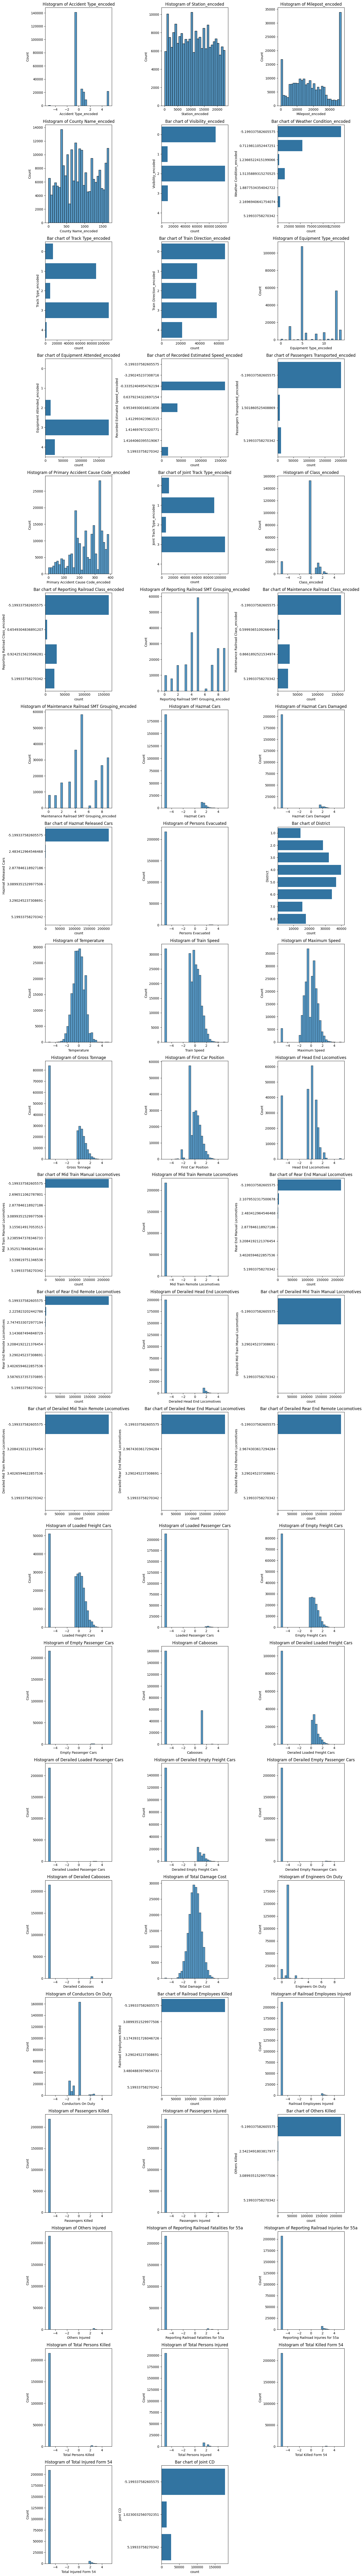

In [ ]:


# Define the number of rows and columns for the subplot grid
n_rows = len(data_qtr.columns) // 3 + (len(data_qtr.columns) % 3 > 0)
n_cols = 3

# Create a large figure to hold the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i, column in enumerate(data_qtr.columns):
    plt.subplot(n_rows, n_cols, i + 1)

    # Check data type of the column
    if data_qtr[column].dtype == 'object' or data_qtr[column].nunique() < 10:
        # If the column is categorical, use a countplot (bar chart)
        sns.countplot(y=column, data=data_qtr)
        plt.title(f'Bar chart of {column}')
        plt.tight_layout()
    else:
        # If the column is numerical, use a histogram
        sns.histplot(data_qtr[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.tight_layout()

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [27]:
X = data_qtr.drop('Total Damage Cost', axis=1)
y = pd.DataFrame(data_qtr['Total Damage Cost'])


As we accessed the financial impact of different railroad accidents, we wanted to experiment with a multitude of regression models which means that as it relates to regularization method (L1 & L2), we needed to take into account any potential multicollinearity as a result we applied the VIF test.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)


# filter out features with VIF greater than 5
high_vif_features = vif_data[vif_data['VIF'] > 5]

print(high_vif_features)


# Get the names of high VIF features
high_vif_feature_names = high_vif_features['feature'].tolist()

# Drop high VIF features from X
X = X.drop(high_vif_feature_names, axis=1)



                  feature         VIF
0   Accident Type_encoded    1.422128
1         Station_encoded    3.993426
2        Milepost_encoded    3.751134
3     County Name_encoded    4.402987
4      Visibility_encoded    2.500889
..                    ...         ...
59   Total Persons Killed  195.333913
60  Total Persons Injured   64.421357
61   Total Killed Form 54  189.563339
62  Total Injured Form 54   65.491794
63               Joint CD    2.528498

[64 rows x 2 columns]
                                      feature          VIF
6                          Track Type_encoded    55.716207
8                      Equipment Type_encoded     6.506345
9                  Equipment Attended_encoded    76.988572
11             Passengers Transported_encoded     6.705959
12        Primary Accident Cause Code_encoded     7.780421
13                   Joint Track Type_encoded    56.359685
15           Reporting Railroad Class_encoded     8.192256
16    Reporting Railroad SMT Grouping_encoded    


We decided on a threshold of 5 (low threshold) to minimize the potential multicollinearity issue within our analysis which drastically reduced the number of relevant features for the model from 64 to 22.













In [29]:
X.columns


Index(['Accident Type_encoded', 'Station_encoded', 'Milepost_encoded',
       'County Name_encoded', 'Visibility_encoded',
       'Weather Condition_encoded', 'Train Direction_encoded',
       'Recorded Estimated Speed_encoded', 'Class_encoded', 'Temperature',
       'Train Speed', 'Maximum Speed', 'Gross Tonnage', 'First Car Position',
       'Head End Locomotives', 'Loaded Freight Cars', 'Empty Freight Cars',
       'Cabooses', 'Derailed Loaded Freight Cars',
       'Derailed Empty Freight Cars', 'Conductors On Duty', 'Joint CD'],
      dtype='object')

Split the data into training and testing set to avoid data leakage

In [30]:
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:


# Define the scalers and model
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}


scaler = scalers['StandardScaler']
X_train_q2sc = scaler.fit_transform(X_train_q2)
X_test_q2sc = scaler.fit_transform(X_test_q2)

y_train_q2sc = scaler.fit_transform(y_train_q2)
y_test_q2sc = scaler.fit_transform(y_test_q2)



# **Lasso Regression**

In [32]:
from sklearn.linear_model import LassoCV
import plotly.express as px

a = 0.1

lassomod = LassoCV(cv=5, alphas=[0.1])

# Assuming X_train_q2sc and y_train_q2sc are your training data
lassomod.fit(X_train_q2sc, y_train_q2sc.ravel())

# Assuming X_test_q2sc and y_test_q2sc are your testing data
pred_lasso = lassomod.predict(X_test_q2sc)

mse_lasso = mean_squared_error(y_test_q2sc, pred_lasso)
r2_lasso = r2_score(y_test_q2sc, pred_lasso)

print(r2_lasso, mse_lasso)


0.09839461364444624 0.9016053863555538




L1 Regularization was applied to get an understanding on the feature importance related to total damage cost with an alpha of 0.01 as a low bound. Kept at such a value given the large amount of features that were pushed to 0.


Rsquared = 0.09839461364444624 and MSE = 0.9016053863555538


In [36]:
coeff = lassomod.coef_
feature_names = X_train_q2.columns

# Create DataFrame for plotting
data = {'Feature': feature_names, 'Coefficient': coeff}
df_plot = pd.DataFrame(data)

# Sort DataFrame based on coefficient values
df_plot = df_plot.reindex(df_plot['Coefficient'].abs().sort_values(ascending=False).index)

# Plotting
fig = px.bar(df_plot, x='Coefficient', y='Feature', orientation='h',
             title='Feature Importance from Lasso Regression',
             labels={'Coefficient': 'Coefficient', 'Feature': 'Feature'}, width=750, height=750)


fig.show()


Maximum speed, Cabooses, gross tonnage and derailed loaded freight cars were the highlighted as the most important features for our model.
Higher speeds may result in more destruction during accidents and as a result would have a direct impact on total damage cost. It also important to note that given a certain track class have a maximum speed limit, certain classes may be susceptible to derailments and as a result play a role as it relates to accidents.

### **Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_train_q2sc and y_train_q2sc are your training data
ridgemod = Ridge(alpha=0.1)
ridgemod.fit(X_train_q2sc, y_train_q2sc)

# Evaluate using cross-validation
ridge_scores = cross_val_score(ridgemod, X_train_q2sc, y_train_q2sc.ravel(), cv=5, scoring='neg_mean_squared_error')
ridge_mse_mean = -ridge_scores.mean()

# Predict on test set
pred_ridge = ridgemod.predict(X_test_q2sc)

# Calculate metrics
mse_ridge = mean_squared_error(y_test_q2sc, pred_ridge)
r2_ridge = r2_score(y_test_q2sc, pred_ridge)

print("Mean CV MSE for Ridge:", ridge_mse_mean)
print("Test MSE for Ridge:", mse_ridge)
print("Test R2 for Ridge:", r2_ridge)

Mean CV MSE for Ridge: 0.8158293328526041
Test MSE for Ridge: 0.8114043740387131
Test R2 for Ridge: 0.18859562596128687




Applied to reduce overfitting with the original 64 features but with the attempt to also obtain a reliable prediction given this new method.

This resulted in rsquared = 0.18859562596124624 and MSE = 0.8114043740387538

The applicable rsquared and MSE value was better than L1 regulazation for prediction. That being said, it was still relatively low and as a result we concluded that it was an overall poor method for developing a model to estimate the total damage costs


### PCA Regression

In an attempt to develop a model in the high dimensionality space (64 features) in the model we wanted to attempt using PCA regression.

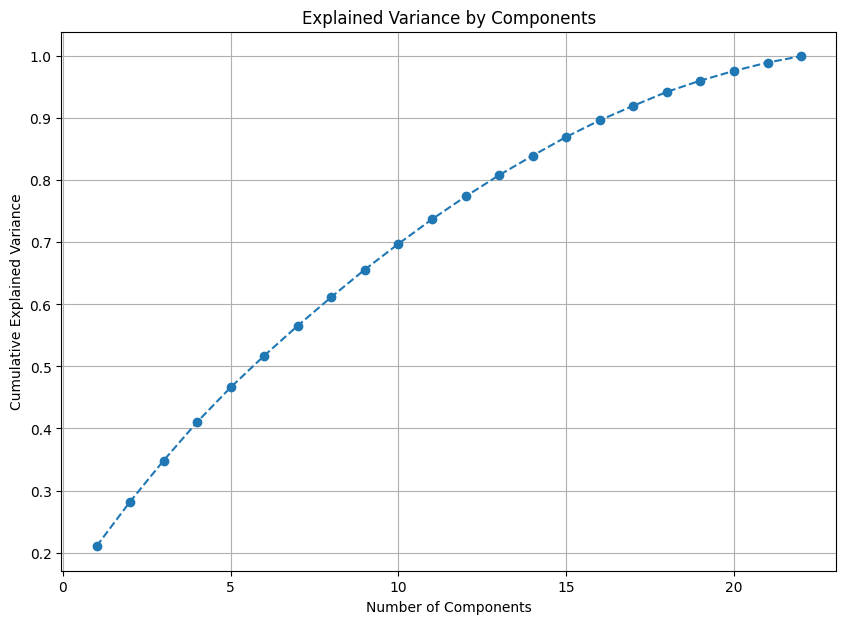

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_q2sc)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


From this plot we can infer that, to incorporate 100% of the variance within the data we would need to apply approximately 22 PC Components.

In [ ]:
X_reduced_train = pca.fit_transform(X_train_q2sc)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)[0:20])
print(X_train_q2.columns[0:20])


[21.02 28.2  34.83 41.04 46.63 51.74 56.57 61.19 65.63 69.77 73.73 77.4
 80.84 83.99 87.   89.68 92.02 94.26 96.08 97.64]
Index(['Accident Type_encoded', 'Station_encoded', 'Milepost_encoded',
       'County Name_encoded', 'Visibility_encoded',
       'Weather Condition_encoded', 'Train Direction_encoded',
       'Recorded Estimated Speed_encoded', 'Class_encoded', 'Temperature',
       'Train Speed', 'Maximum Speed', 'Gross Tonnage', 'First Car Position',
       'Head End Locomotives', 'Loaded Freight Cars', 'Empty Freight Cars',
       'Cabooses', 'Derailed Loaded Freight Cars',
       'Derailed Empty Freight Cars'],
      dtype='object')


In [ ]:
pca


PCA()

In [ ]:
lm = LinearRegression()
pcr_model = lm.fit(X_reduced_train, y_train_q2sc)
print(pcr_model.intercept_)
print(pcr_model.coef_)


[-1.22399665e-18]
[[-0.03723625 -0.10606051 -0.0480763   0.02104313 -0.07606115 -0.00954994
  -0.10140245  0.20127294 -0.06457113 -0.03132326  0.01869917  0.03752423
  -0.2202399   0.17621231 -0.10484481 -0.09403909 -0.02707793 -0.06742839
  -0.09777112 -0.07169298 -0.10926424  0.19062581]]


In [ ]:
y_pred = pcr_model.predict(X_test_q2sc)
np.sqrt(mean_squared_error(y_test_q2sc, y_pred))


1.161220523473799

In [ ]:
r2_score(y_test_q2sc, y_pred)


-0.34843310413676365

In [ ]:
data_qtr['Accident Type_encoded']


0        -0.457033
1         1.233962
2         1.233962
3         0.873515
4         0.670557
            ...   
219198    0.506348
219199   -0.457033
219200   -0.457033
219201    5.199338
219202   -0.457033
Name: Accident Type_encoded, Length: 219203, dtype: float64

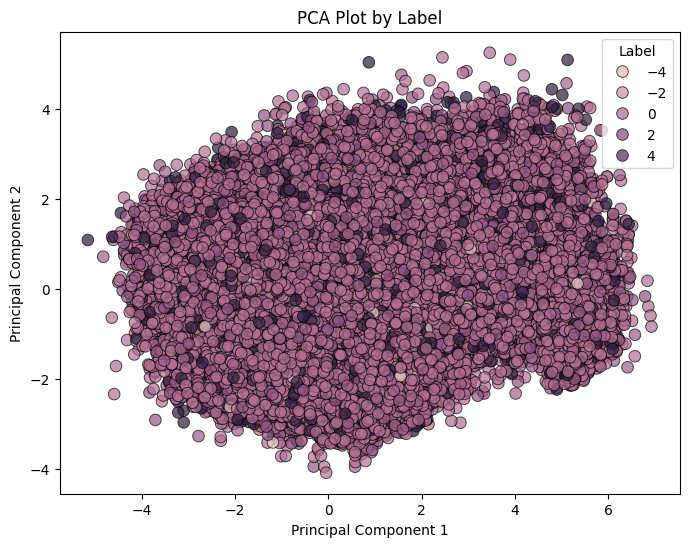

In [ ]:
pca = PCA(n_components=2)  # We choose 2 for easy visualization
principalComponents = pca.fit_transform(X_train_q2sc)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
label =data_qtr['Accident Type_encoded']
merged_df = principalDf.merge(label, left_index=True, right_index=True)

import matplotlib.pyplot as plt
import seaborn as sns
# Now, creating the plot

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=merged_df, s=70, alpha=0.7, edgecolor='k', hue='Accident Type_encoded')
plt.title('PCA Plot by Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.show()


Hard to infer much from this plot.

Our analysis resulted in Rsquared = -0.3484331041356483 and MSE = 1.1612205234733186

With a negative rsquared and higher MSE than ridge regression, we can conclude that PCA regression is not a suitable model to give accurate predictions for this particular problem.



---




##### *Note that other methods such as Kernel Regression, KNN Regression and Support Vector Regression were attempted but various processing and memory problems were incurred in the process and so as a result they were not included* ######



---



We wanted to take another approach at prediction by apply non-parametric models to be able to achieve our objective and potentially capture non-linear relationships within our data.

###**Decision Forest Regression**###

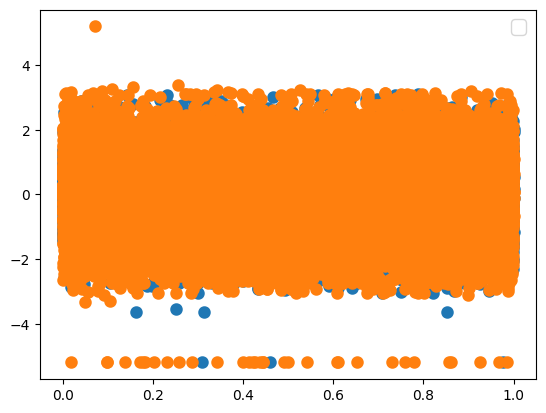

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor



model = DecisionTreeRegressor(min_samples_split=25)
model.fit(X_train_q2, y_train_q2)
dt_model = model.predict(X_test_q2)


t = np.linspace(0, 1, len(dt_model))
#plt.plot(X_train_q2, y_train_q2, 'o', ms=7, mec='k', label="$(x_i,y_i)$")
#plt.plot(np.array(y_test_q2), dt_model, "g", lw=3, label="$y=\\hat{r}(x)$")
plt.scatter(t, dt_model, lw=3)
plt.scatter(t, np.array(y_test_q2), lw=3)
plt.legend(fontsize=14)
plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix
pd.set_option('display.float_format', lambda x: '%.3f' % x)

metrics = [mean_squared_error, mean_absolute_error, mean_absolute_percentage_error]

for metric in metrics:
  result = metric(y_test_q2, dt_model)
  print("{:.8f}".format(result))


0.77424764
0.67986168
4.75188969


Decision Tree Regression

By applying a conservative parameter with a minimum of 25 splits, we were able to obtain a MSE of 0.77424764 which was still less than the result for ridge regression

### Trigonometric polynomial regression ###

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.preprocessing import PolynomialFeatures

class TrigFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=1):
        self.degree = degree

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
          raise ValueError("X.shape[1] != self.n_features_in_")
        # if X.shape[1] > 1:
        #   raise ValueError("TrigFeatures assumes 1-dimensional data.")
        freqs = np.arange(1, self.degree + 1).reshape(1, -1)
        #reshape(-1) refers to an unknown dimension that the reshape() function calculates for you.
        cos_features = np.cos(freqs*X)
        sin_features = np.sin(freqs*X)
        Z = np.hstack([cos_features, sin_features])
        #Stack arrays in sequence horizontally (column wise).
        return Z

check_estimator(TrigFeatures())


In [ ]:

# Initialize variables for optimal degree of the polynomial and error tracking
optimal_degree = None
lowest_error = np.inf
errors = []

degree = 3


# Create a polynomial regression model
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train_q2, y_train_q2)

# Predict on validation set and calculate MSE
Q3_y_test_sub_pred = model.predict(X_test_q2)
mse = mean_squared_error(y_test_q2, Q3_y_test_sub_pred)

# Update optimal degree if current MSE is lower
if mse < lowest_error:
    lowest_error = mse
    optimal_degree = degree

errors.append((optimal_degree, lowest_error))

# Calculate average optimal degree
average_optimal_degree = round(np.mean([e[0] for e in errors]))

# Refit model with the optimal degree
poly_model_optimal = make_pipeline(PolynomialFeatures(average_optimal_degree), LinearRegression())
poly_model_optimal.fit(X_train_q2, y_train_q2)

# Predict on the test set and compute the MSE
Q3_y_test_pred = poly_model_optimal.predict(X_test_q2)
test_mse = mean_squared_error(y_test_q2, Q3_y_test_pred)


(average_optimal_degree, test_mse)


(3, 0.5767204992698848)

In [ ]:
r2_score(y_test_q2, Q3_y_test_pred)


0.43284252001620016

In [ ]:
Adj_r2 = 1 - (1-r2_score(y_test_q2, Q3_y_test_pred)) * (len(y_test_q2)-1)/(len(y_test_q2)-X.shape[1]-1)
print("Adjusted rsquared is ",Adj_r2)


Adjusted rsquared is  0.4325577634193759




We experimented with 1-3 degrees but only presented the best model for the sake of run time.

The best model that was calculated has an optimal degree of 3, MSE of 0.5852072594827421 with an adjusted rsquared of 0.43271341236746097 which is significantly better than all the other models previously attempted.

As a result, even though the resulting model has a relatively low rsquared, we can conclude that there are much more non-linear relationships between the dependent and independent variables.

#**Objective 3: Time Series Analysis**


A time series analysis on accident counts across various states can provide valuable insights into the trends and patterns of accidents over time. This analysis can be used to estimate future accident counts and identify factors that contribute to accidents, helping with accident prevention strategies and resource allocation.

First we will start by tailoring the dateset to fit the model for Time Series Analysis. We do this by getting a frequency of Accident Counts over the years for various states. We will check which works better, doing a Time Series for all the states together or just one state at a time.

In [ ]:
#get the top states with the most accident counts
top_states = df_objective_1['State Code'].value_counts().head(3).index.tolist()

In [ ]:
#Change date column to DateTime
df_objective_1['Date'] = pd.to_datetime(df_objective_1['Date'])

In [ ]:
#Filter the dataset according to the top state
filtered_df = df_objective_1[df_objective_1['State Code'].isin(top_states)]

In [ ]:
#get the frequency of accidents
accident_types_count = filtered_df.groupby(['State Code', 'Accident Type']).size().unstack(fill_value=0)

In [ ]:
filtered_columns_df = filtered_df[['Date', 'State Code', 'Accident Type']]

In [ ]:
filtered_columns_df_2020 = filtered_columns_df[filtered_columns_df]

,Date,State Code,Accident Type
3,1998-12-10,6,Other impacts
19,1996-09-27,17,Other impacts
26,1997-10-17,48,Derailment
36,1999-06-16,6,Derailment
37,2007-05-02,48,Derailment
...,...,...,...
218095,2013-09-13,48,Hwy-rail crossing
218097,2021-09-07,48,Other impacts
218099,2013-10-04,48,Derailment
218100,2011-10-01,48,Rear end collision


In [ ]:
# Filter the DataFrame to include only data for State Code 6
state_6_df = filtered_columns_df[filtered_columns_df['State Code'] == 6]

# Extract the year from the 'Date' column
state_6_df['Year'] = state_6_df['Date'].dt.year

# Group by 'Year' and count the occurrences of accidents for each year
accident_count_by_year = state_6_df.groupby('Date').size().reset_index(name='Accident Count')

<ipython-input-16-c6ea4bffc4f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_6_df['Year'] = state_6_df['Date'].dt.year


In [ ]:
state_6_df['month'] = state_6_df['Date'].dt.year
accident_count_by_date = state_6_df.groupby('month').size().reset_index(name='Accident Count')


<ipython-input-60-97ff1f6d80f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_6_df['month'] = state_6_df['Date'].dt.year


In [ ]:
state_6_df = filtered_columns_df[filtered_columns_df['State Code'] == 6]

# Extract the year and month from the 'Date' column
state_6_df['Year'] = state_6_df['Date'].dt.year
state_6_df['Month'] = state_6_df['Date'].dt.month
state_6_df['Year_Month'] = state_6_df['Date'].dt.to_period('M')

# Group by 'Month' and count the occurrences of accidents for each month
accident_count_by_month = state_6_df.groupby('Month').size().reset_index(name='Accident Count')



<ipython-input-20-83e5dae70927>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_6_df['Year'] = state_6_df['Date'].dt.year
<ipython-input-20-83e5dae70927>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_6_df['Month'] = state_6_df['Date'].dt.month
<ipython-input-20-83e5dae70927>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
filtered_columns_df

,Date,State Code,Accident Type
3,1998-12-10,6,Other impacts
19,1996-09-27,17,Other impacts
26,1997-10-17,48,Derailment
36,1999-06-16,6,Derailment
37,2007-05-02,48,Derailment
...,...,...,...
218095,2013-09-13,48,Hwy-rail crossing
218097,2021-09-07,48,Other impacts
218099,2013-10-04,48,Derailment
218100,2011-10-01,48,Rear end collision


In [ ]:
#get the df for all the states with all the date filters
df_overall_accidents = filtered_columns_df
df_overall_accidents['Year'] = df_overall_accidents['Date'].dt.year
df_overall_accidents['Month'] = df_overall_accidents['Date'].dt.month
df_overall_accidents['Year_Month'] = filtered_columns_df['Date'].dt.to_period('M')
accident_count_by_month_year_overall = filtered_columns_df.groupby(['Year', 'Month']).size().reset_index(name='Accident Count')

<ipython-input-21-ecd85a72aa34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overall_accidents['Year'] = df_overall_accidents['Date'].dt.year
<ipython-input-21-ecd85a72aa34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overall_accidents['Month'] = df_overall_accidents['Date'].dt.month
<ipython-input-21-ecd85a72aa34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
#get the df for all the states with all the date filters after 2020
df_overall_accidents_2020 = df_overall_accidents[df_overall_accidents['Year_Month']> '2020-01']

In [ ]:
#State filter
df_overall_accidents_2020 = df_overall_accidents_2020[df_overall_accidents_2020['State Code'] == 6]

Now we will look at the seasonal plot to see any trend for frequency of accident over the years, we will choose the dataframe which shows the most trend

# Seasonal plot for all the years and all the state

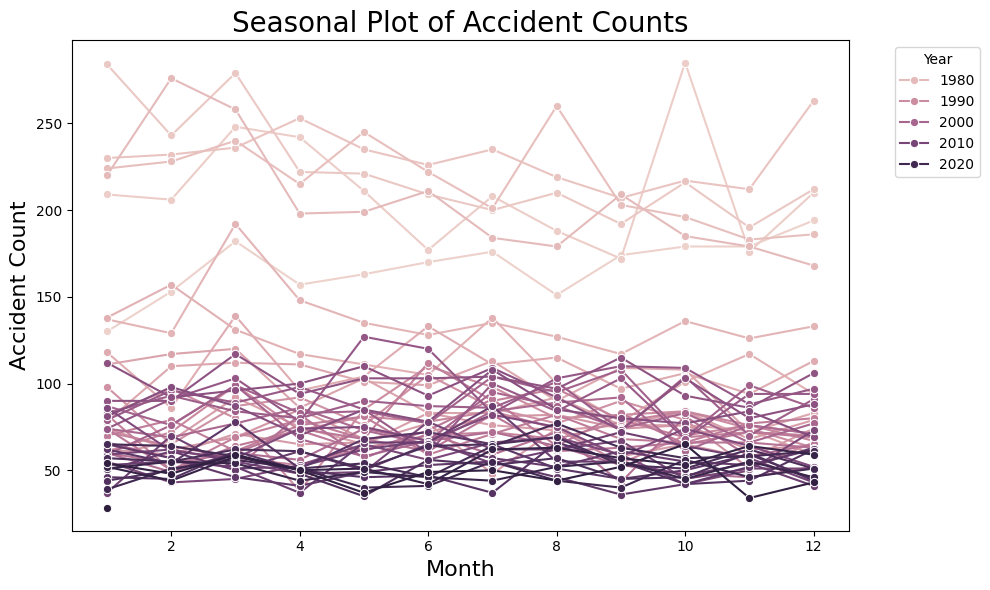

In [ ]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=accident_count_by_month_year_overall, x='Month', y='Accident Count', hue='Year', marker='o')
plt.title('Seasonal Plot of Accident Counts', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Accident Count', fontsize=16)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The Seasonal Plot for all the state and all the years shows no particular trend so we will not be considering this

In [ ]:
accident_count_by_month_year = state_6_df.groupby(['Year', 'Month']).size().reset_index(name='Accident Count')

# Seasonal plot for all the years and only the top state

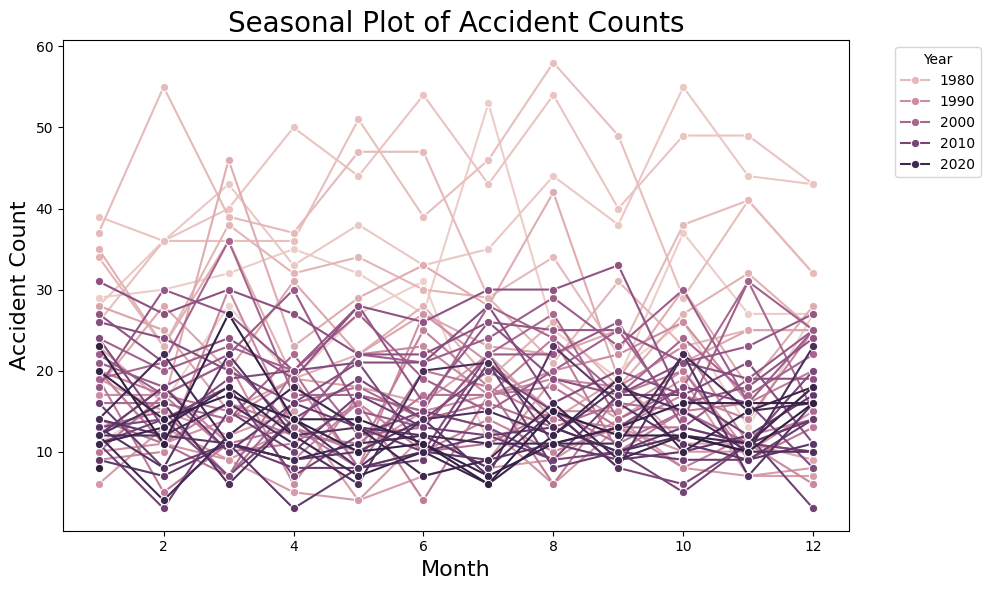

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=accident_count_by_month_year, x='Month', y='Accident Count', hue='Year', marker='o')
plt.title('Seasonal Plot of Accident Counts', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Accident Count', fontsize=16)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The seasonal plot for all the years and top state also shows no particular trend

In [ ]:
accident_count_by_month_year_overall_2020 = accident_count_by_month_year_overall[accident_count_by_month_year_overall['Year'] > 2020]


# Seasonal plot from 2020 and all the states

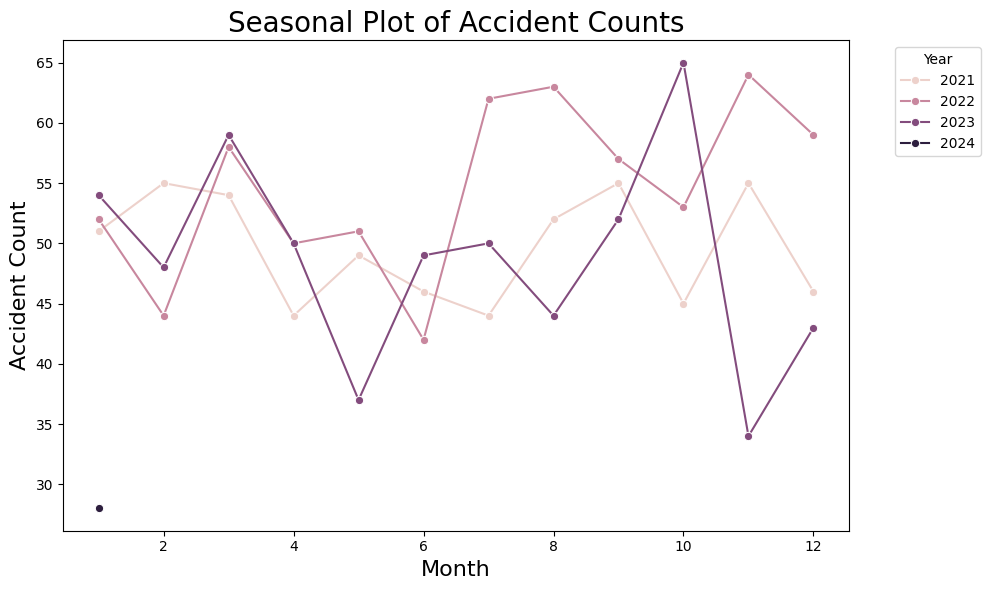

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=accident_count_by_month_year_overall_2020, x='Month', y='Accident Count', hue='Year', marker='o')
plt.title('Seasonal Plot of Accident Counts', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Accident Count', fontsize=16)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The seasonal plot for top state and from the year 2020 shows a slight trend thats common with some of the years so this could be worth investigating

# Seasonal plot for the top state and from the year 2020

In [ ]:
accident_count_by_month_year_2020_state = accident_count_by_month_year[accident_count_by_month_year['Year'] > 2020]

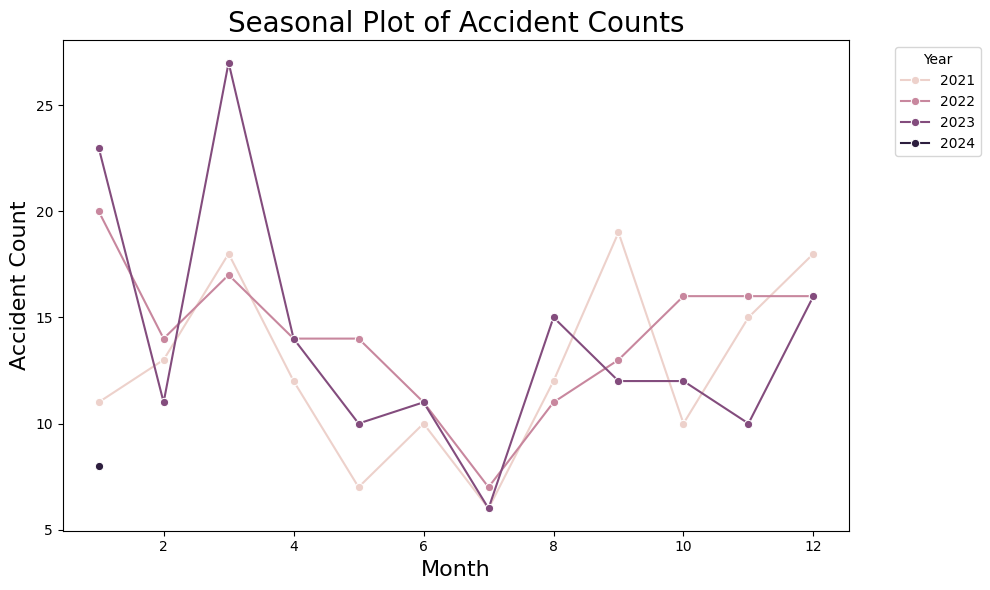

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=accident_count_by_month_year_2020_state, x='Month', y='Accident Count', hue='Year', marker='o')
plt.title('Seasonal Plot of Accident Counts', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Accident Count', fontsize=16)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This plot shows better trend than the last plot, all the years seems to have spikes and dips around the same months. Therefore, we will be going forward with the dataframe that has the top state and only from the year 2021

# Check Year Wise and Monthly plot for the data to see if there is a need for improvements

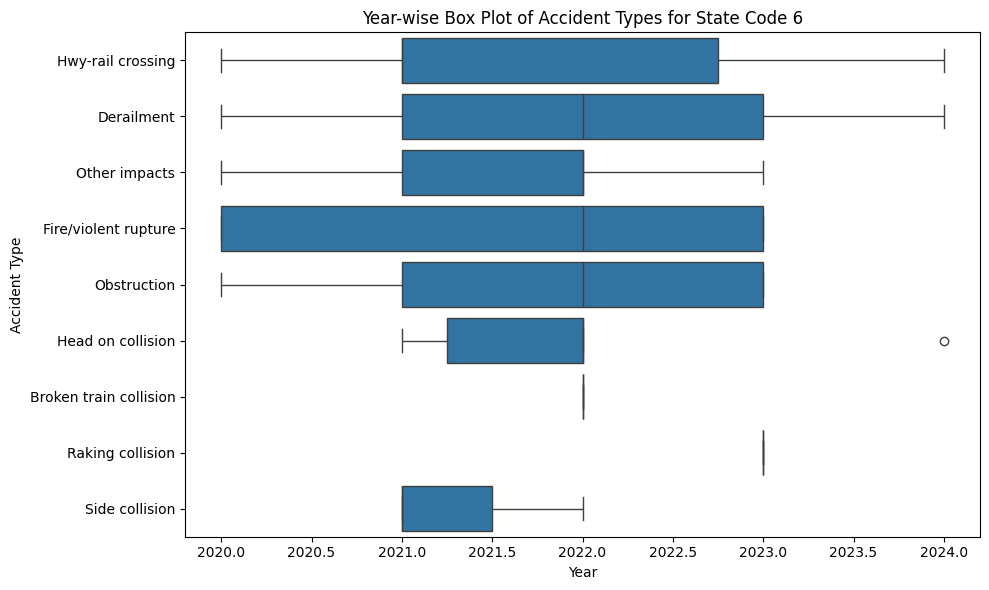

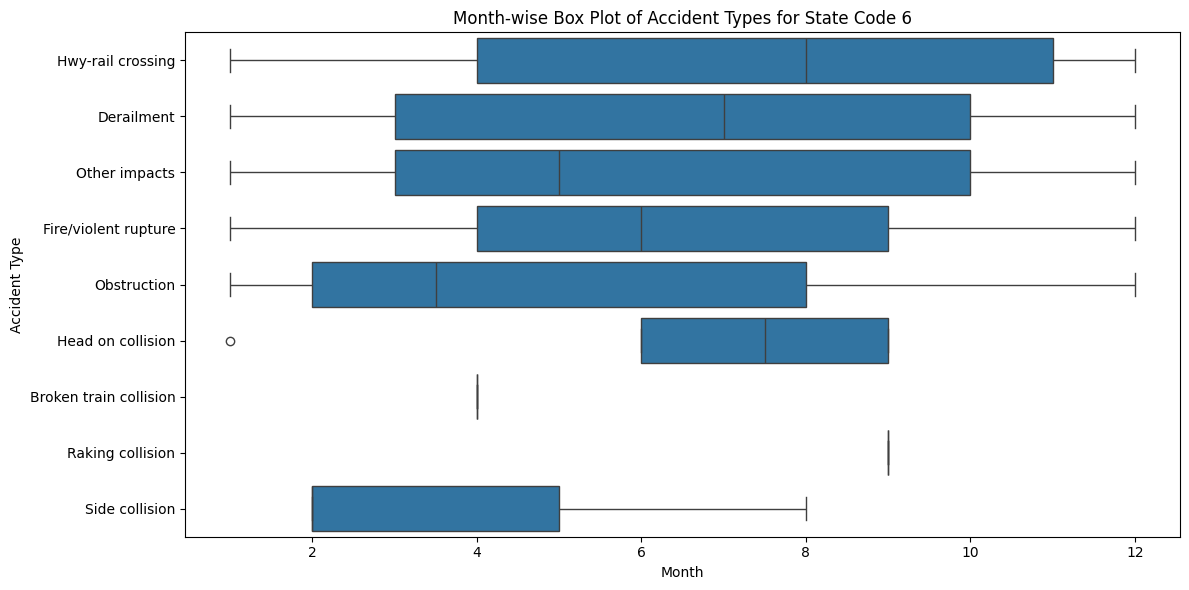

In [ ]:
# Year-wise box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_overall_accidents_2020, x='Year', y='Accident Type')
plt.xlabel('Year')
plt.ylabel('Accident Type')
plt.title('Year-wise Box Plot of Accident Types for State Code 6')
plt.tight_layout()
plt.show()

# Month-wise box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_overall_accidents_2020, x='Month', y='Accident Type')
plt.xlabel('Month')
plt.ylabel('Accident Type')
plt.title('Month-wise Box Plot of Accident Types for State Code 6')
plt.tight_layout()
plt.show()

In [ ]:
accident_count = state_6_df.groupby('Year_Month').size().reset_index(name='Accident Count')
accident_count = accident_count[accident_count['Year_Month'] > '2020-01']

# Stationary check

In [ ]:
result = adfuller(accident_count["Accident Count"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.329611
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


The P value is less than 0 which means we can reject the null hypothesis and the dataframe we have is stationary

# Getting a better idea of the idea with Line plot and histogram

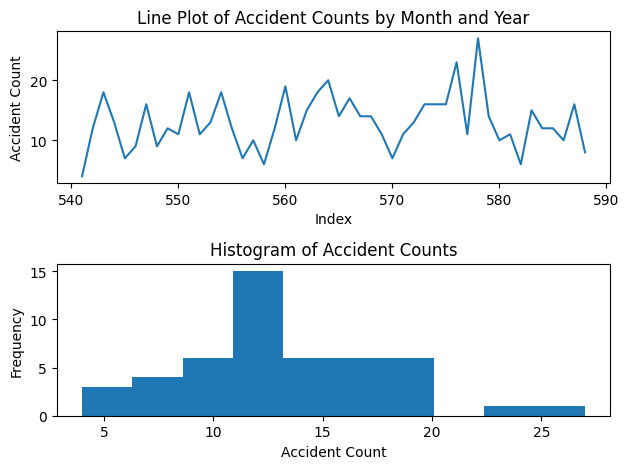

In [ ]:
plt.figure(1)

# Line plot of Accident Counts by Month and Year
plt.subplot(211)
plt.plot(accident_count['Accident Count'])
plt.xlabel('Index')
plt.ylabel('Accident Count')
plt.title('Line Plot of Accident Counts by Month and Year')

# Histogram of Accident Counts
plt.subplot(212)
plt.hist(accident_count['Accident Count'])
plt.xlabel('Accident Count')
plt.ylabel('Frequency')
plt.title('Histogram of Accident Counts')

plt.tight_layout()
plt.show()

These plot seems to fall in line with the ADF test to show that the data is Stationary

# Doing ACF and PACF to find the values of P, Q and D for ARIMA

<Figure size 1200x600 with 0 Axes>

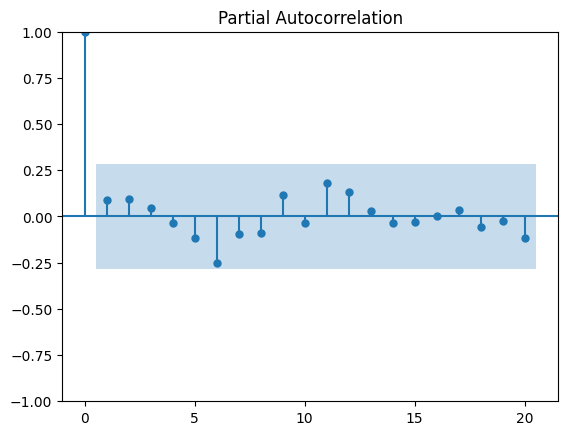

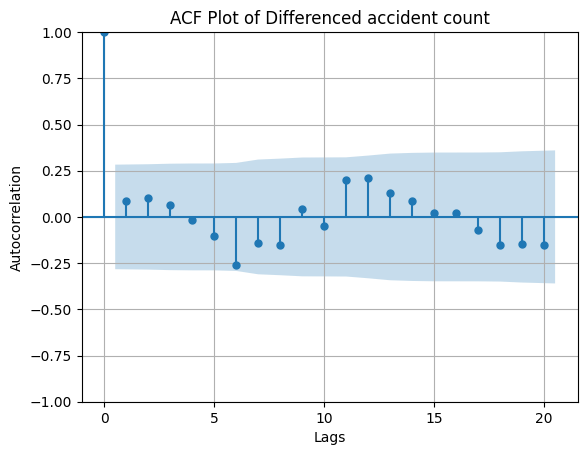

In [ ]:

plt.figure(figsize=(12, 6))
plot_pacf(accident_count["Accident Count"], lags=20, alpha=0.05)
plot_acf(accident_count["Accident Count"], lags=20, alpha=0.05)
plt.title('ACF Plot of Differenced accident count')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Testing the Arima Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Accident Count   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -143.969
Date:                Sat, 13 Apr 2024   AIC                            291.938
Time:                        00:32:57   BIC                            295.639
Sample:                             0   HQIC                           293.331
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5008      0.108     -4.630      0.000      -0.713      -0.289
sigma2        26.6370      6.999      3.806      0.000      12.918      40.356
Ljung-Box (L1) (Q):                   0.66   Jarque-

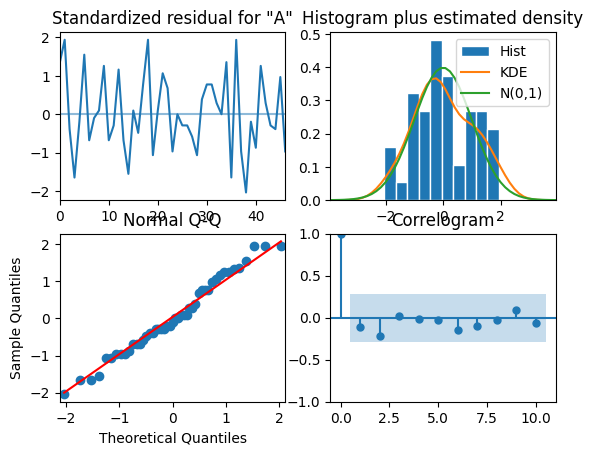

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
p = 1  #value for AR term
d = 1  #value for differencing
q = 0  #value for MA term
model = ARIMA(accident_count['Accident Count'], order=(p, d, q))
result = model.fit()

# Print model summary and diagnostics
print(result.summary())
result.plot_diagnostics()
plt.show()

# Make predictions
forecast_steps = 20  # Number of steps to forecast
forecast = result.forecast(steps=forecast_steps)


In [ ]:

actual = accident_count['Accident Count']
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual[-forecast_steps:], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual[-forecast_steps:], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)

r_squared = r2_score(actual[-forecast_steps:], forecast)

print('R-squared (Coefficient of Determination):', r_squared)
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

R-squared (Coefficient of Determination): -0.2698328481034524
Mean Absolute Error (MAE): 3.8048023068271766
Mean Squared Error (MSE): 30.58709872869191
Root Mean Squared Error (RMSE): 5.530560435316833


The ARIMA model didn't do well in predicting accident counts. Its R-squared value was negative, meaning it explained less than a simple average. The mean absolute error (MAE) was around 3.80, showing the model was off by that much on average. The mean squared error (MSE) and root mean squared error (RMSE) were approximately 30.59 and 5.53, indicating bigger prediction errors, especially when squared. Overall, the model wasn't accurate in forecasting accident counts.

# Testing Holt Winters Method (Triple Exponential)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


R-squared (Testing set): -6.2485
RMSE (Testing set): 7.91


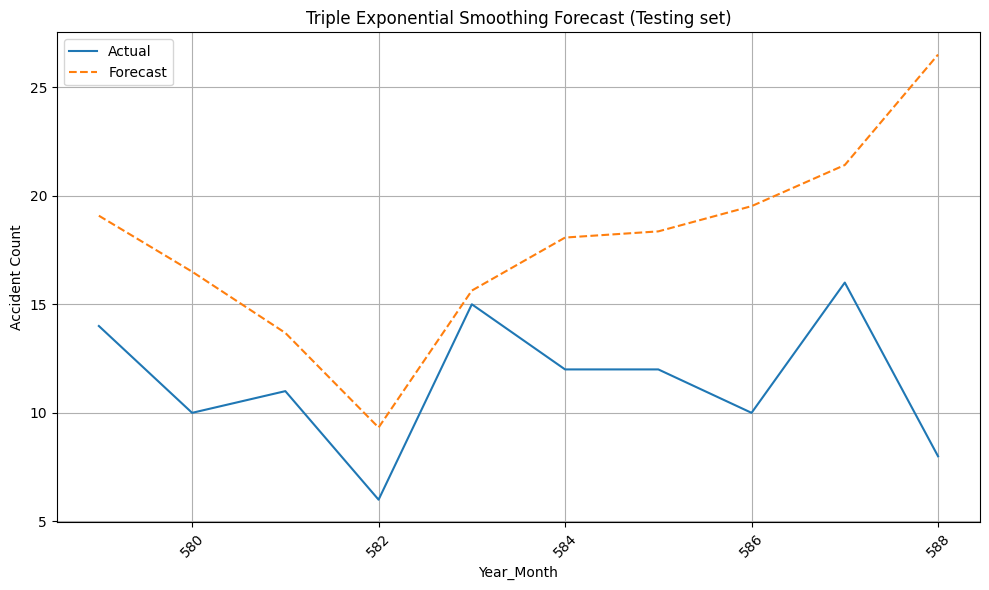

In [ ]:


train_data, test_data = train_test_split(accident_count, test_size=0.2, shuffle=False)

# Perform triple exponential smoothing on the training set
model = ExponentialSmoothing(train_data['Accident Count'],
                             seasonal_periods=12,
                             trend='multiplicative',  # Try additive trend
                             seasonal='multiplicative',  # Try multiplicative seasonal
                             damped_trend=True,  # Add damped trend
                             initialization_method='legacy-heuristic')
fit_model = model.fit()

# Predict values for the testing set (next 20% of periods)
forecast = fit_model.forecast(steps=len(test_data))

# Calculate R-squared and RMSE for the testing set
actual_values = test_data['Accident Count']
predicted_values = forecast
r_squared = r2_score(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print(f"R-squared (Testing set): {r_squared:.4f}")
print(f"RMSE (Testing set): {rmse:.2f}")

# Plotting the forecast for the testing set
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, actual_values, label='Actual')
plt.plot(test_data.index, predicted_values, label='Forecast', linestyle='--')
plt.title('Triple Exponential Smoothing Forecast (Testing set)')
plt.xlabel('Year_Month')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Holt-Winters model didn't do well in explaining the testing data for accident counts. Its R-squared value was negative, showing it didn't perform as well as a simple average. The Root Mean Squared Error (RMSE) was 7.91, meaning the model's predictions were off by around 7.91 units on average compared to the actual counts in the testing data. Overall, the Holt-Winters model didn't accurately predict accident counts in the testing set.

# Testing LSTM

I'm trying out LSTM (Long Short-Term Memory) because it's good at predicting tricky time series data. Time series can be unpredictable, with lots of ups and downs that don't follow a simple pattern. LSTM is designed to handle these kinds of situations by remembering important things from the past and using them to make better predictions.

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1577 - val_loss: 0.4334
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1537 - val_loss: 0.4255
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1498 - val_loss: 0.4177
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.1459 - val_loss: 0.4100
Epoch 5/100
1/1 [==============================] - 0s 54ms/step - loss: 0.1421 - val_loss: 0.4024
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1383 - val_loss: 0.3949
Epoch 7/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1346 - val_loss: 0.3874
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1309 - val_loss: 0.3799
Epoch 9/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1273 - val_loss: 0.3725
Epoch 10/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1237 - val_loss: 0.3651
Epoch 11/100
1/1 [===

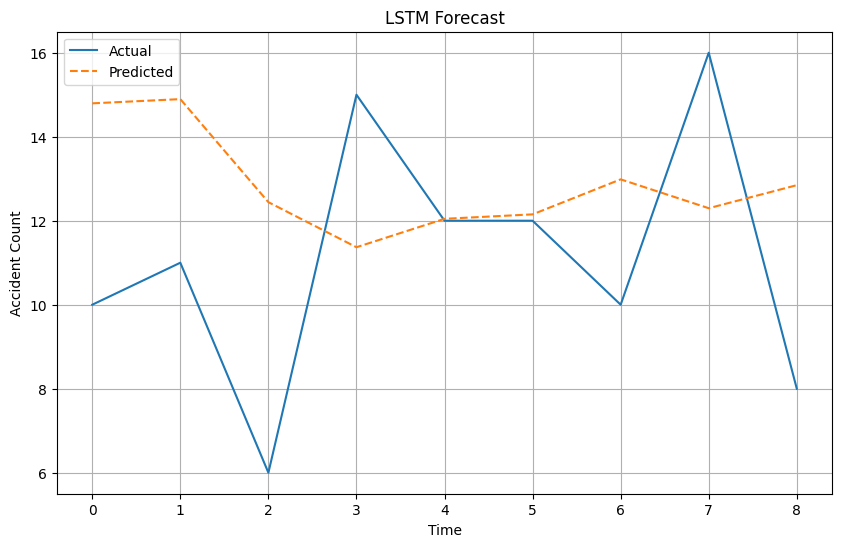

In [ ]:
data = accident_count['Accident Count'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define the number of time steps (e.g., lag periods)
n_steps = 3  # Adjust as needed based on your data
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Reshape the data for LSTM input: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the testing set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R-squared and RMSE for the LSTM model
r_squared = r2_score(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))

print(f"R-squared (LSTM): {r_squared:.4f}")
print(f"RMSE (LSTM): {rmse:.2f}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.show()


The R-squared for the LSTM model is negative, showing it doesn't explain the data well. The RMSE is 3.93, meaning the model's predictions are off by about 3.93 units on average. In simpler terms, the LSTM model isn't doing a good job of understanding or predicting the data.

All these methods were duplicates for all the other Dataframes that were mentioned during the seasonality plot. However, there were no feasible results for any of them proving that Time series Analysis is not viable for this Dataset for predicting the frequency of accidents over the years